In [2]:
# Imports + Paths + DuckDB connect

import duckdb
from pathlib import Path

DATA_DIR = Path("../data")  
PARQUET_PATH = DATA_DIR / "user_funnel_strict.parquet"

assert PARQUET_PATH.exists(), f"Missing: {PARQUET_PATH}"

con = duckdb.connect(database=":memory:")

con.execute(f"""
CREATE VIEW user_funnel AS
SELECT *
FROM read_parquet('{PARQUET_PATH.as_posix()}')
""")

con.execute("SELECT COUNT(*) AS n FROM user_funnel").df()


,n
0,5316128


In [3]:
# 5.1 定义实验单位（unit=user_id，唯一性验证）

unit_check = con.execute("""
SELECT
  COUNT(*) AS rows,
  COUNT(DISTINCT user_id) AS distinct_users,
  (COUNT(*) - COUNT(DISTINCT user_id)) AS duplicates
FROM user_funnel
""").df()

unit_check

null_check = con.execute("""
SELECT
  SUM(CASE WHEN user_id IS NULL THEN 1 ELSE 0 END) AS null_user_id
FROM user_funnel
""").df()
null_check


,null_user_id
0,0.0


In [4]:
# 5.2 设置 Salt（固定常量）

SALT = "pdp_ui_v1"  # 实验名/版本号，固定不变
SALT

'pdp_ui_v1'

In [5]:
# 5.3 Hash 分流（稳定、可复现、≈50/50）

con.execute(f"""
CREATE OR REPLACE VIEW assignment AS
SELECT
  user_id,
  CAST(
    ('0x' || substr(md5(CAST(user_id AS VARCHAR) || '{SALT}'), 1, 8)
    )::UBIGINT % 2 AS INTEGER
  ) AS variant,

  view_time IS NOT NULL AS view,
  cart_time IS NOT NULL AS cart,
  purchase_time IS NOT NULL AS purchase

FROM user_funnel
""")


In [6]:
# 5.3 Verify：是否≈50/50 + 保存分流表

assign_counts = con.execute("""
SELECT
  variant,
  COUNT(*) AS n,
  COUNT(*) * 1.0 / SUM(COUNT(*)) OVER () AS pct
FROM assignment
GROUP BY variant
ORDER BY variant
""").df()

assign_counts


out_path = DATA_DIR / f"assignment_{SALT}.parquet"
con.execute(f"COPY (SELECT * FROM assignment) TO '{out_path.as_posix()}' (FORMAT 'parquet')")
print("Saved:", out_path)

Saved: ..\data\assignment_pdp_ui_v1.parquet


In [7]:
# 5.5 SRM 检查（样本比例检验，p>0.05）

import numpy as np
from scipy.stats import chisquare

counts = con.execute("""
SELECT variant, COUNT(*) AS n
FROM assignment
GROUP BY variant
ORDER BY variant
""").df()

obs = counts["n"].to_numpy()
exp = np.array([obs.sum()/2, obs.sum()/2])

chi2, p = chisquare(f_obs=obs, f_exp=exp)
chi2, p


(0.8679068675547316, 0.3515354286249581)

In [9]:
# 5.6 A/A 测试（在无处理效应下应“不显著”）

from statsmodels.stats.proportion import proportions_ztest

aa = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_users,
  SUM(CASE WHEN purchase THEN 1 ELSE 0 END) AS cart
FROM assignment
GROUP BY variant
ORDER BY variant
""").df()

aa


success = aa["cart"].to_numpy()
nobs = aa["n_users"].to_numpy()

z, p_aa = proportions_ztest(count=success, nobs=nobs)
z, p_aa


(-0.7224388494166887, 0.4700247089282339)

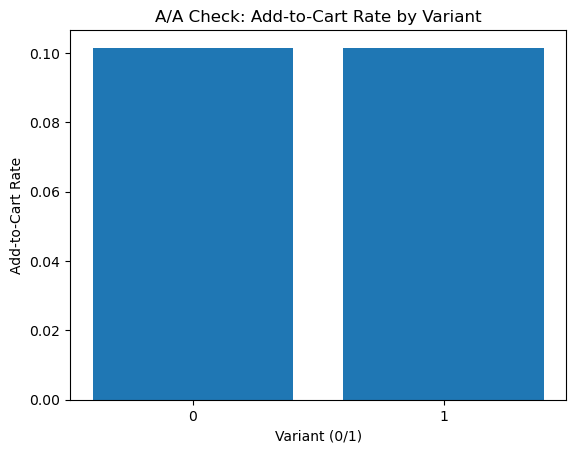

,variant,n_users,cart,add_to_cart_rate
0,0,2659138,269417.0,0.101317
1,1,2656990,269702.0,0.101507


In [12]:
# 5.6 图表输出（A/A add-to-cart rate）

import matplotlib.pyplot as plt

# A/A metric: Add-to-Cart rate
# Assumes `aa` has columns: variant, n_users, add_to_carts (or cart), etc.
# If your count column is named "cart" (as in your current code), keep it.
aa["add_to_cart_rate"] = aa["cart"] / aa["n_users"]

plt.figure()
plt.bar(aa["variant"].astype(str), aa["add_to_cart_rate"])
plt.title("A/A Check: Add-to-Cart Rate by Variant")
plt.xlabel("Variant (0/1)")
plt.ylabel("Add-to-Cart Rate")
plt.show()

aa[["variant", "n_users", "cart", "add_to_cart_rate"]]


We implemented deterministic user-level assignment using a salt-hash scheme to ensure reproducibility and orthogonality across experiments. The assignment split was near 50/50 (2.659M vs 2.657M users). SRM check passed (χ²=0.868, p=0.352), indicating no significant deviation from the expected allocation. An A/A test on baseline add-to-cart rate also showed no significant difference between variants (z=-0.722, p=0.470), supporting that the randomization introduces no systematic imbalance. The final assignment table was materialized to Parquet (assignment_pdp_ui_v1.parquet) for downstream analysis.